In [112]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.cross_validation import cross_val_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
%matplotlib inline

### Read data

In [42]:
data = pd.read_csv("https://gist.githubusercontent.com/armgilles/53e510e179e98acaa11bc68d6b4ebbce/raw/ef2e3d835720aea6125227479fac500f982b04c8/my_data_test.csv")

In [43]:
data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,target
0,1,-0.557099,-1.415828,0,1,0,0,0,0,-1.091727,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.794916,-1.735269,1,1,1,0,1,1,1.295000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,0.254110,-0.457507,1,1,0,0,0,1,1.295000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,-0.827502,-0.138066,1,1,0,0,0,0,-1.688408,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,-0.016293,0.500815,1,1,0,1,1,0,0.698318,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [44]:
data.shape

(863, 37)

In [45]:
y = data.target

In [46]:
data = data.drop('target', axis=1)

In [47]:
y.value_counts(normalize=True)

1.0    0.877173
0.0    0.122827
Name: target, dtype: float64

### Serious business

In [14]:
clf1 = LogisticRegression(class_weight='balanced', solver='newton-cg', C=100.0, random_state=17)
clf2 = xgb.XGBClassifier(n_estimators=5, learning_rate=0.1, max_depth=8, seed=17)
clf3 = xgb.XGBClassifier(n_estimators=7,learning_rate=0.05, max_depth=6, seed=17)
clf4 = LogisticRegression(class_weight='balanced', solver='lbfgs', C=100.0, random_state=17)

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], voting='soft', weights=[1, 4, 4, 1])

for clf, label in zip([clf1, clf2, clf3,clf4, eclf], ['Logistic Newton', 'Xgb1', 
                      'Xgb2', 'Logistic lbfgs', 'Ensemble']):

    scores = cross_val_score(clf, data, y, cv=5, scoring='roc_auc')
    print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

roc_auc: 0.6755 (+/- 0.05) [Logistic Newton]
roc_auc: 0.6304 (+/- 0.04) [Xgb1]
roc_auc: 0.6239 (+/- 0.04) [Xgb2]
roc_auc: 0.6751 (+/- 0.05) [Logistic lbfgs]
roc_auc: 0.6838 (+/- 0.04) [Ensemble]


### Features selection on  (Logistic Newton)

In [18]:
sfs1 = SFS(clf1, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
sfs1 = sfs1.fit(data.values, y.values)

Features: 25/25

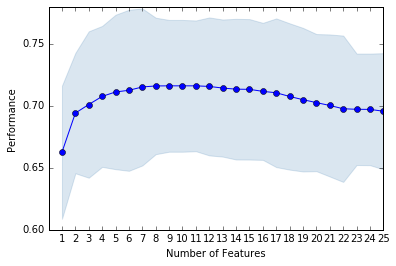

In [20]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

In [22]:
result_clf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict(confidence_interval=0.90)).T
result_clf1.sort_values('avg_score', ascending=0, inplace=True)
result_clf1.head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
10,0.7161,0.0535366,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)",0.0531368,0.0265684
9,0.7161,0.0535366,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 23, 27)",0.0531368,0.0265684
11,0.716091,0.0531213,"[0.690340909091, 0.806704260652, 0.66146326080...","(1, 34, 35, 4, 5, 9, 15, 21, 22, 23, 27)",0.0527245,0.0263623
8,0.71601,0.0554486,"[0.691238038278, 0.812969924812, 0.66114790287...","(1, 34, 4, 5, 23, 9, 27, 21)",0.0550345,0.0275172
12,0.715621,0.0560501,"[0.683612440191, 0.812343358396, 0.66099022390...","(1, 34, 35, 4, 5, 9, 11, 15, 21, 22, 23, 27)",0.0556315,0.0278158


We want the best avg_score so we take the first row of feature_idx

In [23]:
best_features_clf1 = result_clf1.feature_idx.head(1).tolist()

In [24]:
select_features_clf1 = data.columns[best_features_clf1]
select_features_clf1

Index([u'col_1', u'col_34', u'col_4', u'col_5', u'col_9', u'col_15', u'col_21',
       u'col_22', u'col_23', u'col_27'],
      dtype='object')

Let's do a CV just to be sure :

In [29]:
cross_val_score(clf1, data[select_features_clf1], y, cv=5, scoring='roc_auc').mean()

0.7161000125992284

Ok, we have the same result as our best result_clf1 ! :)

### Let's do again our EnsembleVoteClassifier with our new features selections

In [31]:
for clf, label in zip([clf1, clf2, clf3,clf4, eclf], ['Logistic Newton', 'Xgb1', 
                      'Xgb2', 'Logistic lbfgs', 'Ensemble']):

    scores = cross_val_score(clf, data[select_features_clf1], y, cv=5, scoring='roc_auc')
    print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

roc_auc: 0.7161 (+/- 0.05) [Logistic Newton]
roc_auc: 0.6790 (+/- 0.04) [Xgb1]
roc_auc: 0.6735 (+/- 0.04) [Xgb2]
roc_auc: 0.7161 (+/- 0.05) [Logistic lbfgs]
roc_auc: 0.7218 (+/- 0.05) [Ensemble]


We now have better result for our Ensemble (0.7218 / 0.6838)

## Let's try to have the best features selection for our xgb2 (lowest AUC)

In [32]:
sfs2 = SFS(clf3, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
sfs2 = sfs2.fit(data.values, y.values)

Features: 25/25

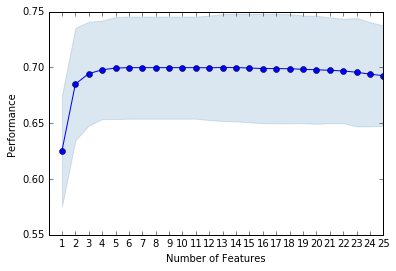

In [33]:
fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_dev')

In [34]:
result_clf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict(confidence_interval=0.90)).T
result_clf2.sort_values('avg_score', ascending=0, inplace=True)
result_clf2.head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
13,0.699897,0.0482455,"[0.753289473684, 0.753289473684, 0.65184484389...","(1, 34, 35, 5, 13, 15, 19, 22, 24, 27, 29, 30,...",0.0478852,0.0239426
14,0.699845,0.0485822,"[0.752093301435, 0.754542606516, 0.65263323872...","(1, 34, 35, 5, 13, 15, 19, 22, 24, 25, 27, 29,...",0.0482194,0.0241097
9,0.699766,0.0460857,"[0.748056220096, 0.752192982456, 0.65373699148...","(1, 13, 15, 19, 22, 24, 27, 29, 30)",0.0457416,0.0228708
11,0.699766,0.0460857,"[0.748056220096, 0.752192982456, 0.65373699148...","(1, 34, 35, 13, 15, 19, 22, 24, 27, 29, 30)",0.0457416,0.0228708
10,0.699766,0.0460857,"[0.748056220096, 0.752192982456, 0.65373699148...","(1, 34, 13, 15, 19, 22, 24, 27, 29, 30)",0.0457416,0.0228708


So we can improve our AUC score to 0.6998 (standart was 0.6239 and 1st features selection was 0.6735)

In [35]:
best_features_clf2 = result_clf2.feature_idx.head(1).tolist()

In [36]:
select_features_clf2 = data.columns[best_features_clf2]
select_features_clf2

Index([u'col_1', u'col_34', u'col_35', u'col_5', u'col_13', u'col_15',
       u'col_19', u'col_22', u'col_24', u'col_27', u'col_29', u'col_30',
       u'col_31'],
      dtype='object')

As we can see, select_features_clf1 & select_features_clf2 are not the same

In [38]:
cross_val_score(clf3, data[select_features_clf2], y, cv=5, scoring='roc_auc').mean()

0.6998966787830504

### Let's do again (3) our EnsembleVoteClassifier with our new features selections (clf3)

In [40]:
for clf, label in zip([clf1, clf2, clf3,clf4, eclf], ['Logistic Newton', 'Xgb1', 
                      'Xgb2', 'Logistic lbfgs', 'Ensemble']):

    scores = cross_val_score(clf, data[select_features_clf2], y, cv=5, scoring='roc_auc')
    print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

roc_auc: 0.6823 (+/- 0.06) [Logistic Newton]
roc_auc: 0.7061 (+/- 0.05) [Xgb1]
roc_auc: 0.6999 (+/- 0.05) [Xgb2]
roc_auc: 0.6823 (+/- 0.06) [Logistic lbfgs]
roc_auc: 0.7104 (+/- 0.06) [Ensemble]


## Results :
    - Our Ensemble (features selection clf3: 0.7104) is lower than our Ensemble (features selection clf1: 0.7218)
    - But our last Xgb2 is is higher from our first features selection (0.6999 vs 0.6735)

## Questions :
    - Is could nice to use for each Estimators (clf) in our Ensemble (EnsembleVoteClassifier) the best features selection to perform a better score
    - Do we need to tune (gridsearchCV) our clf on all features or on features selections ?
    - Do we need to tune our Ensemble (Weight) on all features or on features selections (on ensemble) ?
    

___

## Using Pipieline to do it 

In [176]:
from sklearn.pipeline import Pipeline

In [178]:
# CLF1 : Logistic Newton
sfs1 = SFS(clf1, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
#sfs1 = sfs1.fit(data.values, y.values)

clf1_pipe = Pipeline([('sfs1', sfs1),
                      ('Logistic Newton', clf1)])

# CLF2 : Xgb1
sfs2 = SFS(clf2, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
#sfs2 = sfs2.fit(data.values, y.values)

clf2_pipe = Pipeline([('sfs2', sfs2),
                      ('Xgb1', clf2)])

# CLF3 : Xgb2
sfs3 = SFS(clf3, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
sfs3 = sfs3.fit(data.values, y.values)

#clf3_pipe = Pipeline([('sfs3', sfs3),
                      ('Xgb2', clf3)])

# CLF4 : Logistic lbfgs
sfs4 = SFS(clf4, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)
#sfs4 = sfs4.fit(data.values, y.values)

clf4_pipe = Pipeline([('sfs4', sfs4),
                      ('Logistic lbfgs', clf4)])


Features: 25/25

In [337]:
# Ensemble
eclf = EnsembleVoteClassifier(clfs=[clf1_pipe, clf2_pipe, clf3_pipe, clf4_pipe],
                              voting='soft')

In [281]:
for clf, label in zip([clf1_pipe, clf2_pipe, clf3_pipe, clf4_pipe, eclf], 
                      ['Logistic Newton', 'Xgb1', 'Xgb2', 'Logistic lbfgs', 'Ensemble']):

    scores = cross_val_score(clf, data.values, y.values, cv=5, scoring='roc_auc')
    print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Features: 25/25

roc_auc: 0.6544 (+/- 0.07) [Logistic Newton]
roc_auc: 0.6620 (+/- 0.05) [Xgb1]

Features: 25/25


roc_auc: 0.6575 (+/- 0.04) [Xgb2]

Features: 25/25


roc_auc: 0.6542 (+/- 0.07) [Logistic lbfgs]

Features: 25/25


roc_auc: 0.6687 (+/- 0.07) [Ensemble]


In [284]:
# CV for our first Estimator Pipeline (Logistic Newton)
scores = cross_val_score(clf1_pipe, data.values, y.values, cv=5, scoring='roc_auc')

Features: 25/25

In [287]:
print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Newton'))

roc_auc: 0.6544 (+/- 0.07) [Logistic Newton]


Our score is **lower** than precious try (*0.7161*). It seems that our SFS (features selection) doesn't take the best score but the last features selection (aka score with *SFS.k_features*)

In [298]:
# Our first SFS for clf1
print "First SFS for clf1 : " + str(best_features_clf1)

print "Pipeline SFS with clf1 : " + str(clf1_pipe.named_steps['sfs1'].k_feature_idx_)

First SFS for clf1 : [(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)]
Pipeline SFS with clf1 : (0, 1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 25, 27, 29, 30, 31, 34, 35)


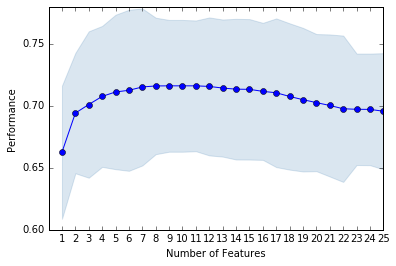

In [210]:
fig1bis = plot_sfs(clf1_pipe.named_steps['sfs1'].get_metric_dict(), kind='std_dev')



As you can see on this graph, the best performance is with 10 features and during the pipeline process we take the performance of 25 features

In [219]:
result_clf1_pipe = pd.DataFrame.from_dict(clf1_pipe.named_steps['sfs1'].get_metric_dict(confidence_interval=0.90)).T
result_clf1_pipe.sort_values('avg_score', ascending=0, inplace=True)
result_clf1_pipe.head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
10,0.7161,0.0535366,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)",0.0531368,0.0265684
9,0.7161,0.0535366,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 23, 27)",0.0531368,0.0265684
11,0.716091,0.0531213,"[0.690340909091, 0.806704260652, 0.66146326080...","(1, 34, 35, 4, 5, 9, 15, 21, 22, 23, 27)",0.0527245,0.0263623
8,0.71601,0.0554486,"[0.691238038278, 0.812969924812, 0.66114790287...","(1, 34, 4, 5, 23, 9, 27, 21)",0.0550345,0.0275172
12,0.715621,0.0560501,"[0.683612440191, 0.812343358396, 0.66099022390...","(1, 34, 35, 4, 5, 9, 11, 15, 21, 22, 23, 27)",0.0556315,0.0278158


## How can we take the features selection with the best performance (SFS) during a Pipeline process ?

------------------------------

## Find Manually the best k_features for SFS and fit our ensemble 

### clf1 - Logistic Newton

In [301]:
sfs1_manual = SFS(clf1, 
               k_features=10, #seems the best 
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs1_manual = sfs1_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs1_manual.k_feature_idx_)
print "Score : " + str(sfs1_manual.k_score_)

Features: 10/10

Feature selection (1, 34, 4, 5, 9, 15, 21, 22, 23, 27)
Score : 0.716100012599


In [303]:
sfs1_manual_df = pd.DataFrame.from_dict(sfs1_manual.get_metric_dict()).T
sfs1_manual_df.sort_values('avg_score', ascending=0, inplace=True)
sfs1_manual_df.head(3)

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
9,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 23, 27)",0.0531368,0.0265684
10,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)",0.0531368,0.0265684
8,0.71601,0.0707353,"[0.691238038278, 0.812969924812, 0.66114790287...","(1, 34, 4, 5, 23, 9, 27, 21)",0.0550345,0.0275172


### clf2 - Xgboost 1

In [307]:
# Looking for best number of k_features
sfs2_manual = SFS(clf2, 
               k_features=len(data.columns), #All features
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs2_manual = sfs2_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs2_manual.k_feature_idx_)
print "Score : " + str(sfs2_manual.k_score_)

Features: 36/36

Feature selection (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
Score : 0.630448411818


In [306]:
sfs2_manual_df = pd.DataFrame.from_dict(sfs2_manual.get_metric_dict()).T
sfs2_manual_df.sort_values('avg_score', ascending=0, inplace=True)
sfs2_manual_df.head(3)

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
15,0.709337,0.0569933,"[0.740879186603, 0.776002506266, 0.68148848943...","(1, 34, 3, 5, 35, 33, 8, 13, 15, 19, 22, 23, 2...",0.0443427,0.0221714
14,0.709308,0.0563241,"[0.740879186603, 0.773966165414, 0.67959634184...","(1, 34, 3, 5, 35, 33, 8, 13, 15, 19, 22, 27, 2...",0.043822,0.021911
16,0.708846,0.0564633,"[0.739683014354, 0.775062656642, 0.68117313150...","(1, 34, 3, 5, 35, 33, 8, 11, 13, 15, 19, 22, 2...",0.0439304,0.0219652


** --> 15 seems the best number of k_features**

In [308]:
sfs2_manual = SFS(clf2, 
               k_features=15, # Best numbers 
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs2_manual = sfs2_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs2_manual.k_feature_idx_)
print "Score : " + str(sfs2_manual.k_score_)

Features: 15/15

Feature selection (1, 34, 3, 5, 35, 33, 8, 13, 15, 19, 22, 23, 27, 29, 30)
Score : 0.709336603474


### clf3 - Xgboost 2

In [309]:
# Looking for best number of k_features
sfs3_manual = SFS(clf3, 
               k_features=len(data.columns), #All features
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs3_manual = sfs3_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs3_manual.k_feature_idx_)
print "Score : " + str(sfs3_manual.k_score_)

Features: 36/36

Feature selection (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
Score : 0.623919955669


In [310]:
sfs3_manual_df = pd.DataFrame.from_dict(sfs3_manual.get_metric_dict()).T
sfs3_manual_df.sort_values('avg_score', ascending=0, inplace=True)
sfs3_manual_df.head(3)

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
13,0.699897,0.0615464,"[0.753289473684, 0.753289473684, 0.65184484389...","(1, 34, 35, 5, 13, 15, 19, 22, 24, 27, 29, 30,...",0.0478852,0.0239426
14,0.699845,0.061976,"[0.752093301435, 0.754542606516, 0.65263323872...","(1, 34, 35, 5, 13, 15, 19, 22, 24, 25, 27, 29,...",0.0482194,0.0241097
6,0.699766,0.0587912,"[0.748056220096, 0.752192982456, 0.65373699148...","(1, 19, 24, 13, 30, 29)",0.0457416,0.0228708


** --> 13 seems the best number of k_features**

In [312]:
sfs3_manual = SFS(clf3, 
               k_features=13, # Best numbers 
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs3_manual = sfs3_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs3_manual.k_feature_idx_)
print "Score : " + str(sfs3_manual.k_score_)

Features: 13/13

Feature selection (1, 34, 35, 5, 13, 15, 19, 22, 24, 27, 29, 30, 31)
Score : 0.699896678783


### clf4 - Logistic lbfgs

In [313]:
# Looking for best number of k_features
sfs4_manual = SFS(clf4, 
               k_features=len(data.columns), #All features
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs4_manual = sfs4_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs4_manual.k_feature_idx_)
print "Score : " + str(sfs4_manual.k_score_)

Features: 36/36

Feature selection (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
Score : 0.675050736414


In [314]:
sfs4_manual_df = pd.DataFrame.from_dict(sfs4_manual.get_metric_dict()).T
sfs4_manual_df.sort_values('avg_score', ascending=0, inplace=True)
sfs4_manual_df.head(3)

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
9,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 23, 27)",0.0531368,0.0265684
10,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)",0.0531368,0.0265684
11,0.716091,0.0677664,"[0.690340909091, 0.806704260652, 0.66146326080...","(1, 34, 35, 4, 5, 9, 15, 21, 22, 23, 27)",0.0527245,0.0263623


** --> 9 seems the best number of k_features**

In [315]:
sfs4_manual = SFS(clf4, 
               k_features=9, #Best numbers 
               forward=True, 
               floating=False, 
               scoring='roc_auc',
               cv=5)
sfs4_manual = sfs4_manual.fit(data.values, y.values)

print "Feature selection " + str(sfs4_manual.k_feature_idx_)
print "Score : " + str(sfs4_manual.k_score_)

Features: 9/9

Feature selection (1, 34, 4, 5, 9, 15, 21, 23, 27)
Score : 0.716100012599


### Eclf - Ensemble

In [317]:
clf1_pipe_manual = Pipeline([('sfs1_manual', sfs1_manual),
                              ('Logistic Newton', clf1)])

clf2_pipe_manual = Pipeline([('sfs2_manual', sfs2_manual),
                              ('Xgb1', clf2)])

clf3_pipe_manual = Pipeline([('sfs3_manual', sfs3_manual),
                              ('Xgb2', clf3)])

clf4_pipe_manual = Pipeline([('sfs4_manual', sfs4_manual),
                              ('Logistic lbfgs', clf4)])



eclf = EnsembleVoteClassifier(clfs=[clf1_pipe_manual, clf2_pipe_manual, 
                                    clf3_pipe_manual, clf4_pipe_manual],
                              voting='soft')


In [318]:
for clf, label in zip([clf1_pipe_manual, clf2_pipe_manual, clf3_pipe_manual, clf4_pipe_manual, eclf], 
                      ['Logistic Newton', 'Xgb1', 'Xgb2', 'Logistic lbfgs', 'Ensemble']):

    scores = cross_val_score(clf, data.values, y.values, cv=5, scoring='roc_auc')
    print("roc_auc: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Features: 15/15

roc_auc: 0.6387 (+/- 0.08) [Logistic Newton]
roc_auc: 0.6698 (+/- 0.05) [Xgb1]

Features: 13/13


roc_auc: 0.6603 (+/- 0.04) [Xgb2]

Features: 9/9


roc_auc: 0.6474 (+/- 0.08) [Logistic lbfgs]

Features: 9/9


roc_auc: 0.6564 (+/- 0.08) [Ensemble]


## Looking for the bad score in SFS  Pipeline :

#### The score of our CLF1 was 0.6387 (+/- 0.08) with the pipeline process and 0.7161 (+/- 0.05)) with the manual SFS. Searching why ...

In [329]:
# SFS with full numbers of k_features
sfs1_manual_all = SFS(clf1, 
                   k_features=len(data.columns), 
                   forward=True, 
                   floating=False, 
                   scoring='roc_auc',
                   cv=5)
sfs1_manual_all = sfs1_manual_all.fit(data.values, y.values)

print "Feature selection " + str(sfs1_manual_all.k_feature_idx_)
print "Score : " + str(sfs1_manual_all.k_score_)


Features: 36/36

Feature selection (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
Score : 0.675488559599


In [330]:
sfs1_manual_all = pd.DataFrame.from_dict(sfs1_manual_all.get_metric_dict()).T
sfs1_manual_all

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.662581,0.068987,"[0.691686602871, 0.743577694236, 0.61857458215...","(1,)",0.0536742,0.0268371
2,0.694117,0.0623785,"[0.706040669856, 0.768327067669, 0.64001892147...","(1, 9)",0.0485326,0.0242663
3,0.701039,0.0758659,"[0.698863636364, 0.791823308271, 0.65231788079...","(1, 23, 9)",0.0590263,0.0295131
4,0.707582,0.0730441,"[0.713217703349, 0.804824561404, 0.66083254493...","(27, 1, 23, 9)",0.0568308,0.0284154
5,0.711155,0.0800364,"[0.708283492823, 0.814223057644, 0.63954588457...","(23, 1, 27, 5, 9)",0.0622711,0.0311355
6,0.712508,0.0834603,"[0.705293062201, 0.817355889724, 0.63923052664...","(1, 34, 5, 23, 9, 27)",0.064935,0.0324675
7,0.715193,0.0813482,"[0.67793062201, 0.825031328321, 0.655786818038...","(1, 34, 5, 23, 9, 27, 21)",0.0632917,0.0316458
8,0.71601,0.0707353,"[0.691238038278, 0.812969924812, 0.66114790287...","(1, 34, 4, 5, 23, 9, 27, 21)",0.0550345,0.0275172
9,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 23, 27)",0.0531368,0.0265684
10,0.7161,0.0682963,"[0.689443779904, 0.807644110276, 0.66146326080...","(1, 34, 4, 5, 9, 15, 21, 22, 23, 27)",0.0531368,0.0265684


No SFS avg_score match with the score find during the Pipeline process (0.6387)

In [331]:
from IPython.display import Image

In [335]:
Image(url="http://i.giphy.com/ePeHKwWSed0Ag.gif")